In [1]:
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# open pickle file
with open('/content/drive/MyDrive/figs_class.pickle', 'rb') as handle:
  x_train, y_train, x_test, y_test = pickle.load(handle)

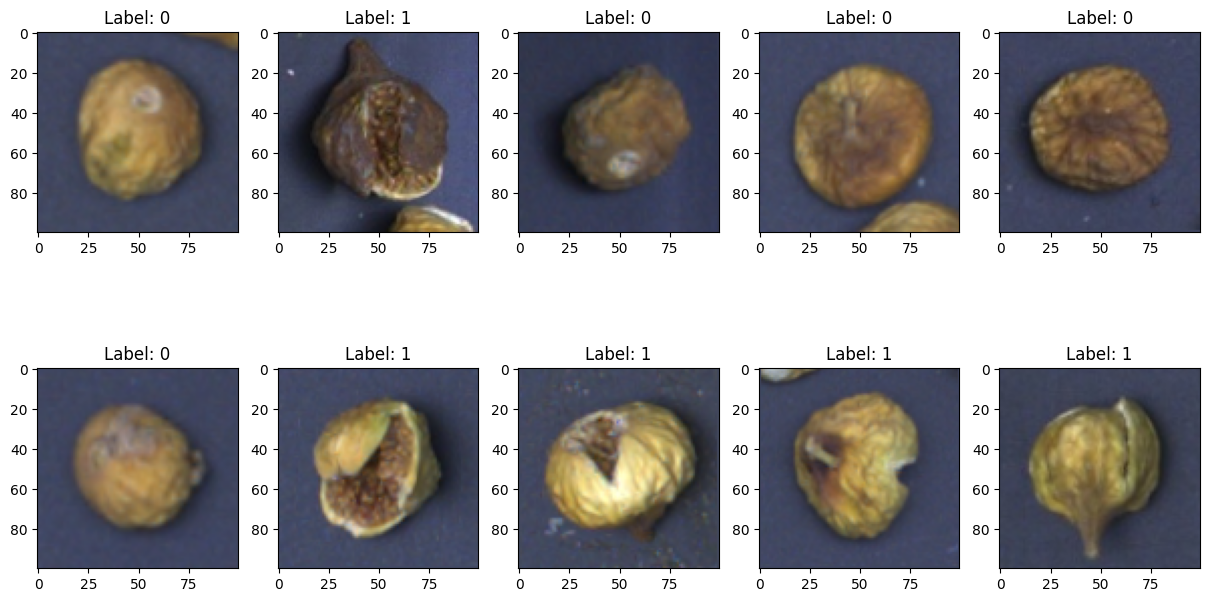

In [ ]:
num_images = 10

random_indices=random.sample(range(len(x_train)),num_images)

images=[x_train[i] for i in random_indices]
labels = [y_train[i] for i in random_indices]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
axes = axes.flatten()
for i in range(num_images):
    axes[i].imshow(images[i][:,:,::-1])
    axes[i].set_title(f'Label: {labels[i]}')
plt.show()

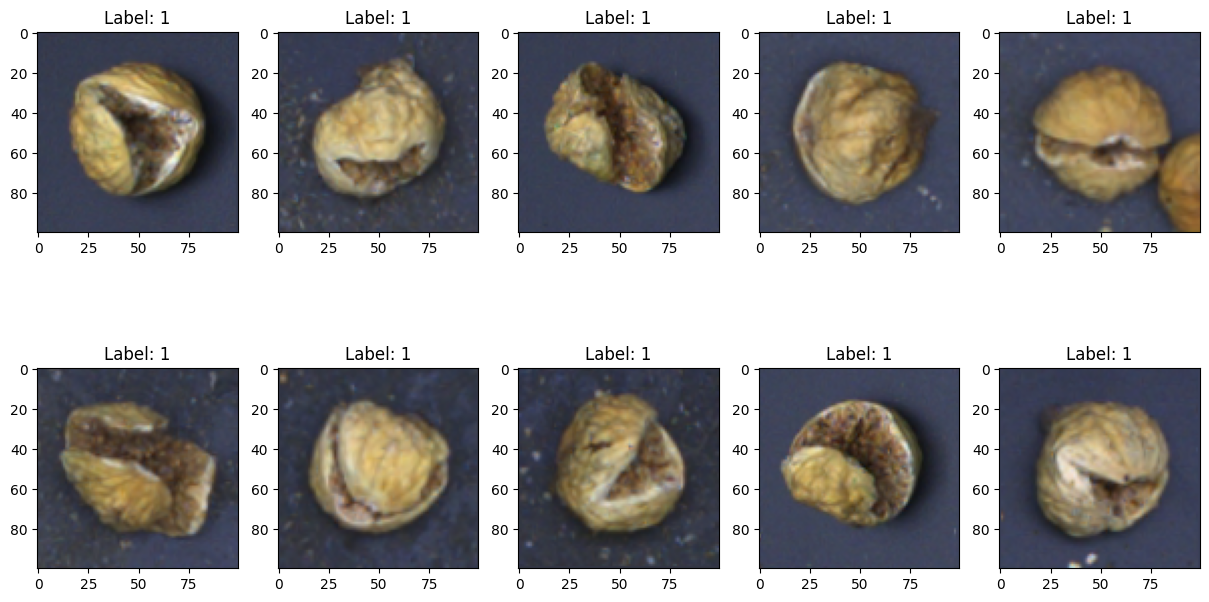

In [ ]:
num_images = 10

images = []
labels = []
for i in range(len(y_train)):
    if y_train[i] == 1:
        images.append(x_train[i])
        labels.append(y_train[i])
        if len(images) == num_images:
            break

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
axes = axes.flatten()
for i in range(num_images):
    axes[i].imshow(images[i][:,:,::-1])
    axes[i].set_title(f'Label: {labels[i]}')
plt.show()

In [2]:
!pip install autokeras

In [3]:
import autokeras as ak

Using TensorFlow backend


In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Define the image data generator with augmentation techniques
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

In [7]:
# Generate augmented data
augmented_train_data = train_datagen.flow(x_train, y_train)

In [16]:
# Concatenate the augmented data with the original data
x_train_augmented = x_train.copy()
y_train_augmented = y_train.copy()

for data in range(len(augmented_train_data)):
    x_train_augmented = np.concatenate((x_train_augmented, augmented_train_data[data][0]), axis=0)
    y_train_augmented = np.concatenate((y_train_augmented, augmented_train_data[data][1]), axis=0)

In [9]:
print(x_train_augmented.shape,y_train_augmented.shape)

(5786, 100, 100, 3) (5786,)


In [10]:
print(len(y_train_augmented[y_train_augmented>0])/len(y_train_augmented))

0.3446249567922572


In [17]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# count number each class
class_counts = Counter(y_train_augmented)

minority_class = min(class_counts, key=class_counts.get)
print(minority_class)


x_train_reshaped = np.reshape(x_train_augmented, (x_train_augmented.shape[0], -1))

print(x_train_augmented.shape,x_train_reshaped.shape)
n,img_width, img_height, img_channels=x_train_augmented.shape

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_reshaped, y_train_augmented)
x_train_resampled = x_train_resampled.reshape(-1, img_width, img_height, img_channels)

print(x_train_resampled.shape,y_train_resampled.shape)

1
(5786, 100, 100, 3) (5786, 30000)
(7584, 100, 100, 3) (7584,)


In [12]:
print(len(y_train_resampled[y_train_resampled>0])/len(y_train_resampled))

0.5


In [13]:
from keras.callbacks import EarlyStopping
# Define the EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

In [14]:
from keras.callbacks import ModelCheckpoint
# Define the ModelCheckpoint callback.
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True, mode='max',
                             verbose=1)

In [19]:

x = x_train_resampled
y = y_train_resampled


n_samples = x.shape[0]


perm = np.random.permutation(n_samples)


x_train_resampled = x[perm]
y_train_resampled = y[perm]

In [21]:
print(y_train_resampled.shape)

print(y_train_resampled[:100])

(7584,)
[1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0
 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1]


In [22]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation data
x_train_aug, x_val, y_train_aug, y_val = train_test_split(x_train_resampled, y_train_resampled, test_size=0.2)

In [23]:
import tensorflow as tf

# Define a custom objective function that combines training accuracy and validation accuracy
def custom_objective(y_true, y_pred):
    train_acc = tf.keras.metrics.Accuracy()(y_true, y_pred)
    val_acc = tf.keras.metrics.Accuracy()(y_val, clf.predict(x_val))
    return 0.5 * train_acc + 0.5 * val_acc

In [25]:
import tensorflow as tf
image_size=[64,80,100]

input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
# output_node = tf.keras.layers.experimental.preprocessing.Resizing(height=image_size[0], width=image_size[1])(input_node)
output_node = ak.ImageAugmentation(horizontal_flip=True)(output_node)
output_node = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.ClassificationHead()(output_node)

clf = ak.AutoModel(
    inputs=input_node
    , outputs=output_node
    , overwrite=True
    , max_trials=10
    ,objective="val_accuracy"
)



In [26]:
history=clf.fit(x_train_aug,
    y_train_aug,
    validation_data=(x_val, y_val),
    epochs=20,
    callbacks=[early_stop])


Trial 10 Complete [00h 06m 49s]
val_accuracy: 0.8272907137870789

Best val_accuracy So Far: 0.9189189076423645
Total elapsed time: 01h 51m 31s


In [27]:
model2 = clf.export_model()
model2.save('resnet2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from sklearn.metrics import accuracy_score

print(x_test.shape)
predictions = model2.predict(x_test)
predicted_labels = []
for i in predictions :
  if i>=0.5:
    predicted_labels.append(1)
  else:
    predicted_labels.append(0)


accuracy = accuracy_score(y_test, predicted_labels)
print('Test accuracy:', accuracy)

(749, 100, 100, 3)
24/24 [==============================] - 6s 151ms/step
Test accuracy: 0.8958611481975968


In [29]:
import tensorflow as tf

# Load the model from the H5 file
model3 = tf.keras.models.load_model('/content/resnet2.h5')

In [30]:
from sklearn.metrics import accuracy_score

print(x_test.shape)
predictions = model3.predict(x_test)
predicted_labels = []
for i in predictions :
  if i>=0.5:
    predicted_labels.append(1)
  else:
    predicted_labels.append(0)


accuracy = accuracy_score(y_test, predicted_labels)
print('Test accuracy:', accuracy)

(749, 100, 100, 3)
24/24 [==============================] - 5s 148ms/step
Test accuracy: 0.8958611481975968


In [31]:
from sklearn.metrics import accuracy_score

print(x_test.shape)
predictions = model3.predict(x_train)
predicted_labels = []
for i in predictions :
  if i>=0.5:
    predicted_labels.append(1)
  else:
    predicted_labels.append(0)


accuracy = accuracy_score(y_train, predicted_labels)
print('Test accuracy:', accuracy)

(749, 100, 100, 3)
91/91 [==============================] - 13s 146ms/step
Test accuracy: 0.9491876944348427
